In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import itertools

import numpy as np

import nltk
from nltk.tokenize.regexp  import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from keras.layers import Bidirectional, Input, LSTM, Flatten,Dense, Activation
from keras.layers.embeddings import Embedding

from keras.optimizers import Adam
from keras.models import Model
import keras.backend as K
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.models import Sequential
import pickle
%matplotlib  inline


C:\Users\EMO\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_df = pd.read_pickle('Tra.p')
test_df = pd.read_pickle('Tes.p')
valid_df = pd.read_pickle('Val.p')

y_train = np.array(pd.get_dummies(train_df['Emoji']))
y_test = np.array(pd.get_dummies(test_df['Emoji']))
y_valid = np.array(pd.get_dummies(valid_df['Emoji']))

In [3]:
lemmatizer = WordNetLemmatizer()
def convert_to_lem(text):
    tokens = []
    for word in  nltk.word_tokenize(text, language='english'):
        #if len(word) < 2:
            #continue
        tokens.append(lemmatizer.lemmatize(word.lower()))
    return tokens

def tokenize_on_whitespace(sent):
    result = []
    for w in WhitespaceTokenizer().tokenize(sent):
        result.append(w.lower())
    return result

def untokenize(lst):
    result = ''
    for w in lst:
        result = result + " "+ str(w)
    return result
def calculate_metrix(y_test,pred):
    acc = accuracy_score(y_test, pred)
    #print('acc: %s' % acc)
    micro_f1 = f1_score(y_test, pred,average='micro')
    #print('F1 micro: {:.2f}'.format(micro_f1))
    macro_f1 = f1_score(y_test, pred,average='macro')
    #print('F1 macro: {:.2f}'.format(macro_f1))
    micro_precision = precision_score(y_test, pred, average = 'micro')
    #print('Micro-averaged precision = {:.2f} (treat instances equally)'
          .format(micro_precision))
    macro_precision = precision_score(y_test, pred, average = 'macro')
    #print('Macro-averaged precision = {:.2f} (treat classes equally)'
          .format(macro_precision))
    micro_recall = recall_score(y_test, pred, average = 'micro')
    #print('Micro-averaged recall = {:.2f} (treat instances equally)'
          .format(micro_recall))
    macro_recall = recall_score(y_test, pred, average = 'macro')
    #print('Macro-averaged recall = {:.2f} (treat classes equally)'
          .format(macro_recall))
    return [acc, micro_f1, macro_f1, micro_precision, macro_precision, micro_recall, macro_recall]


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    my_tags = train_df['Emoji'].unique()
    tick_marks = np.arange(len(my_tags))
    target_names = tick_marks
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True Emoji')
    plt.xlabel('Predicted Emoji')

    
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    cm = confusion_matrix(target, predictions)
    #print('confusion matrix\n %s' % cm)
    #print('(row=expected, col=predicted)')
    metrix = calculate_metrix(predictions,target)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #plot_confusion_matrix(cm_normalized, title + ' Normalized')
    return metrix

150164    52
387521    52
79671     46
151256    45
479672    44
214038    43
184062    42
8766      41
283195    40
5906      40
Name: Text, dtype: int64


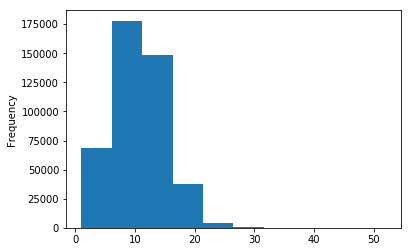

In [13]:
tokens = train_df['Text'].apply(convert_to_lem)
tokens = tokens.apply(lambda x: len(x))
tokens.plot.hist()
print(tokens.sort_values(ascending=False).head(10))
max_num_words = (tokens.max())

In [4]:
def read_my_glove_vecs(w2v_map):
    my_word_to_vec_map = pickle.load(open(w2v_map,"rb"))
    my_words = my_word_to_vec_map.keys()
    my_words_to_index = {}
    my_index_to_words = {}
    i = 1
    for w in sorted(my_words):
        my_words_to_index[w] = i
        my_index_to_words[i] = w
        i = i + 1
    return my_words_to_index, my_index_to_words, my_word_to_vec_map


def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        anom = 0
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            vec = np.array(line[1:], dtype=np.float64)
            if vec.shape[0] == emb_dim:
                words.add(curr_word)
                word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            else:
                anom += 1
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    #print(anom)
    return words_to_index, index_to_words, word_to_vec_map
emb_dim = 50

In [8]:
add_lem_word_to_index, add_lem_index_to_word, add_lem_word_to_vec_map = read_my_glove_vecs('lemmas_and_normal.p')

150164    52
387521    52
79671     46
151256    45
479672    44
214038    43
184062    42
5906      40
283195    40
8766      40
Name: Text, dtype: int64


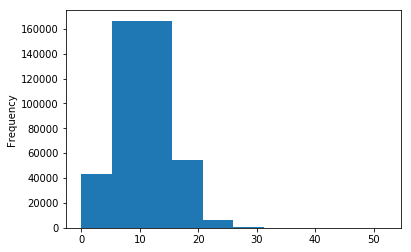

In [9]:
def max_seq_len_eval(lst):
    i = 0
    for i in range(len(lst)):
        if lst[i] in add_lem_word_to_index:
            i += 1
        elif lst[i].lower() in add_lem_word_to_index:
            i += 1
        elif lemmatizer.lemmatize(lst[i].lower()) in add_lem_word_to_index:
            i += 1
    return i

add_lem_word_to_index, add_lem_index_to_word, add_lem_word_to_vec_map = read_my_glove_vecs('lemmas_and_normal.p')
tokens = train_df['Text'].apply(convert_to_lem)
tokens = tokens.apply(max_seq_len_eval)
tokens.plot.hist()
print(tokens.sort_values(ascending=False).head(10))
del tokens
del add_lem_word_to_index
del add_lem_index_to_word
del add_lem_word_to_vec_map

In [10]:
emb_dim = 50
timestemps = 35

In [20]:
lem_word_to_index, lem_index_to_word, lem_word_to_vec_map = read_my_glove_vecs('w2v_lemas_map.p')
low_word_to_index, low_index_to_word, low_word_to_vec_map = read_my_glove_vecs('w2v_low_map.p')
add_lem_word_to_index, add_lem_index_to_word, add_lem_word_to_vec_map = read_my_glove_vecs('lemmas_and_normal.p')
add_low_word_to_index, add_low_index_to_word, add_low_word_to_vec_map = read_my_glove_vecs('low_and_normal.p')

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.twitter.27B.'+str(emb_dim)+'d.txt')


In [12]:

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1                 
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))    
    embedding_layer.set_weights([emb_matrix])    
    return embedding_layer
def Bidirectinal_Context_Dense(word_to_vec_map, word_to_index):
    
    sentence_indices = Input(shape = (timestemps,), dtype=np.int32)
    
    embedding_layer =  pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices)
    
    X = Bidirectional(LSTM(64, return_sequences=True))(embeddings)
    X = Dropout(0.4)(X)
    X = LSTM(64, return_sequences=False)(X)
    X = Dropout(0.4)(X)
    X = Dense(20)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices, outputs=X)
    return model
model1 = Bidirectinal_Context_Dense(word_to_vec_map, word_to_index)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 35)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 35, 50)            59675700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 35, 128)           58880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
__________

In [13]:
def LSTM_Context_Dense(word_to_vec_map, word_to_index):

    sentence_indices = Input(shape=(timestemps,),dtype=np.int32)
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices)   
    
    X = LSTM(128,return_sequences=True)(embeddings)
    X = Dropout(0.4)(X)
    X = LSTM(64)(X)
    X = Dropout(0.4)(X)
    X = Dense(20)(X)
    X = Activation('softmax')(X)
    
    model = Model(sentence_indices,X)
        
    return model
model2 = LSTM_Context_Dense(word_to_vec_map, word_to_index)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 35)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 35, 50)            59675700  
_________________________________________________________________
lstm_3 (LSTM)                (None, 35, 128)           91648     
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
__________

In [14]:
def simple_model():

    model = Sequential()
    model.add(Dense(50, input_shape=(emb_dim,), activation='tanh'))
    model.add(Dense(20, input_shape=(emb_dim,), activation='softmax'))
    return model
model3 = linier_model()
del word_to_index, index_to_word, word_to_vec_map
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1020      
Total params: 3,570
Trainable params: 3,570
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_score_tabel(number_models, number_of_emmbedings_models):
    params_scores = ["accuracy","micro_f1", "macro_f1", "micro_precision", "macro_precision", "micro_recall", "macro_recall"]
    params_scores_test = [v +"_test" for v in params_scores]
    params_scores_train = [v +"_train" for v in params_scores]
    header = ["embedings","model"]+params_scores_test + params_scores_train
    result_df = pd.DataFrame(index=range(number_models * number_of_emmbedings_models),columns=header)
    return result_df


def fill(df,idx,vals):
    print(vals)
    for col in range(len(vals)):
        df.iloc[idx,col] = vals[col] 
    print(df)
    return df


def average_words(array, word_to_vec_map):
    """compute average tweet vectors"""
    average_vec_list = []
    for row in array:
        average = np.zeros((emb_dim,))    
        for w in row:
            average += w
        average = average / len(row)
        average_vec_list.append(average)
    return np.array(average_vec_list)
    


def search_best_arhitecture_and_emmbedings(train_df, test_df, epoch = 1, b_size=128):

    
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()
    
    
    def txt_to_idx(lst):
        result =  np.zeros((timestemps))
        for i in range(min(len(lst),timestemps)):
            if lst[i] in word_to_index:
                result[i] = word_to_index[lst[i]]
            elif lst[i].lower() in word_to_index:
                result[i] = word_to_index[lst[i].lower()]
            elif lemmatizer.lemmatize(lst[i].lower()) in word_to_index:
                result[i] = word_to_index[lemmatizer.lemmatize(lst[i].lower())]
        return result
    
    train_lowercased_txt = train_df_copy['Text'].apply(tokenize_on_whitespace)
    test_lowercased_txt = test_df_copy['Text'].apply(tokenize_on_whitespace)
    
    train_lemmatized_txt = train_df_copy['Text'].apply(convert_to_lem)
    test_lemmatized_txt = test_df_copy['Text'].apply(convert_to_lem)
    
    del train_df_copy
    del test_df_copy
    
    my_glove_vectors_names = ["lemmas_and_normal_linear.p","low_and_normal_linear.p",
                              "concat_lemmas_and_normal.p","concat_low_and_normal.p",'w2v_low_map.p',
                              'w2v_lemas_map.p', 'lemmas_and_normal.p', 'low_and_normal.p']
    stanford_vectors = ['glove.twitter.27B.'+str(emb_dim)+'d.txt']
    all_glove_vect_names = my_glove_vectors_names + stanford_vectors
    anotations = ["lemmas and stanford","lowercased and stanford","concatinated my lemmas and stanford",
                  "concatinated my lowercased and stanford","trained on my corpus lowercased words",
                  "trained on my corpus lowercased and lemmatized words", 
                  "trained on my corpus lemmatized + stanford", "trained on my corpus lowercased + stanford","stanford w2v"]
    result_df = get_score_tabel(len(anotations),3)
    result_idx = 0
    for i in range(len(all_glove_vect_names)):
        anot = anotations[i]            
        if i == len(all_glove_vect_names)-1:
            word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(all_glove_vect_names[i])
        else:
            word_to_index, index_to_word, word_to_vec_map = read_my_glove_vecs(all_glove_vect_names[i])
        if ((i == 5) or (i == 6) or (i==2)or(i==0)):
            X_train = train_lemmatized_txt
            X_test = test_lemmatized_txt
        else:
            X_train = train_lowercased_txt
            X_test = test_lowercased_txt
        X_train = np.array(X_train.apply(txt_to_idx).values.tolist())
        X_test = np.array(X_test.apply(txt_to_idx).values.tolist())
        
        l_model = simple_model()
        
        
        l_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        l_model.fit(average_words(X_train, word_to_vec_map), y_train, epochs=epoch, batch_size=b_size, shuffle=True)
        predictions = l_model.predict(average_words(X_test, word_to_vec_map), batch_size=b_size, verbose=0)
        test_scores = evaluate_prediction(np.argmax(predictions,axis=1), np.argmax(y_test,axis=1))
        predictions = l_model.predict(average_words(X_train,word_to_vec_map), batch_size=b_size, verbose=0)
        train_scores = evaluate_prediction(np.argmax(predictions,axis=1), np.argmax(y_train,axis=1))
        scores = [anot,"Word avg. model"] + test_scores + train_scores
        result_df = fill(result_df,result_idx,scores)
        result_idx += 1
        
        LCD_model = LSTM_Context_Dense(word_to_vec_map, word_to_index)
        
        LCD_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        LCD_model.fit(X_train, y_train, epochs=epoch, batch_size=b_size, shuffle=True)
        predictions = LCD_model.predict(X_test, batch_size=b_size, verbose=0)
        test_scores = evaluate_prediction(np.argmax(predictions,axis=1), np.argmax(y_test,axis=1))
        predictions = LCD_model.predict(X_train, batch_size=b_size, verbose=0)
        train_scores = evaluate_prediction(np.argmax(predictions,axis=1), np.argmax(y_train,axis=1))
        scores = [anot,"LSTM_Context_Densel"] + test_scores + train_scores
        result_df = fill(result_df,result_idx,scores)
        result_idx += 1 
        
        BCD_model = Bidirectinal_Context_Dense(word_to_vec_map, word_to_index)        
        BCD_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        BCD_model.fit(X_train, y_train, epochs=epoch, batch_size=b_size, shuffle=True)
        predictions = BCD_model.predict(X_test, batch_size=b_size, verbose=0)
        test_scores = evaluate_prediction(np.argmax(predictions,axis=1), np.argmax(y_test,axis=1))
        predictions = BCD_model.predict(X_train, batch_size=b_size, verbose=0)
        train_scores = evaluate_prediction(np.argmax(predictions,axis=1), np.argmax(y_train,axis=1))
        scores = [anot,"Bidirectinal_Context_Dense"] + test_scores + train_scores
        result_df = fill(result_df,result_idx,scores)
        result_idx += 1
        
        
        
    return result_df
        

        
result_table = search_best_arhitecture_and_emmbedings(train_df,test_df, 3, b_size=64)

In [21]:
def pretrained_embedding_layer2(word_to_vec_map, word_to_index, Trin_emb):
    vocab_len = len(word_to_index) + 1                 
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=Trin_emb)
    embedding_layer.build((None,))    
    embedding_layer.set_weights([emb_matrix])    
    return embedding_layer

def Bidirectinal_Context_Dense(word_to_vec_map, word_to_index, Trin_emb = False, bi_dir_dim=64,dropout=0.4):
    
    sentence_indices = Input(shape = (timestemps,), dtype=np.int32)
    
    embedding_layer =  pretrained_embedding_layer2(word_to_vec_map, word_to_index, Trin_emb)
    
    embeddings = embedding_layer(sentence_indices)
    
    X = Bidirectional(LSTM(bi_dir_dim, return_sequences=True))(embeddings)
    X = Dropout(dropout)(X)
    X = LSTM(bi_dir_dim, return_sequences=False)(X)
    X = Dropout(dropout)(X)
    X = Dense(20)(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    return model

word_to_index, index_to_word, word_to_vec_map = read_my_glove_vecs('low_and_normal.p')
model1 = Bidirectinal_Context_Dense(word_to_vec_map, word_to_index,True)
model1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 35)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 35, 50)            59891500  
_________________________________________________________________
bidirectional_9 (Bidirection (None, 35, 128)           58880     
_________________________________________________________________
dropout_33 (Dropout)         (None, 35, 128)           0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 20)                1300      
__________

In [23]:
def txt_to_idx(lst):
    result =  np.zeros((timestemps))
    for i in range(min(len(lst),timestemps)):
        if lst[i] in word_to_index:
            result[i] = word_to_index[lst[i]]
        elif lst[i].lower() in word_to_index:
            result[i] = word_to_index[lst[i].lower()]
        elif lemmatizer.lemmatize(lst[i].lower()) in word_to_index:
            result[i] = word_to_index[lemmatizer.lemmatize(lst[i].lower())]
    return result

In [ ]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()
b_size = 64
   
X_train = train_df_copy['Text'].apply(tokenize_on_whitespace)
X_test = test_df_copy['Text'].apply(tokenize_on_whitespace)

X_train = np.array(X_train.apply(txt_to_idx).values.tolist())
X_test = np.array(X_test.apply(txt_to_idx).values.tolist())

word_to_index, index_to_word, word_to_vec_map = read_my_glove_vecs('low_and_normal.p')
BCD_model = Bidirectinal_Context_Dense(word_to_vec_map, word_to_index, True)
        
BCD_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sc_test = []
sc_train = []
for i in range(10):
    BCD_model.fit(X_train, y_train, epochs=1, batch_size=b_size, shuffle=True)
    predictions = BCD_model.predict(X_test, batch_size=b_size, verbose=0)
    test_scores = evaluate_prediction(np.argmax(predictions,axis=1), np.argmax(y_test,axis=1))
    predictions = BCD_model.predict(X_train, batch_size=b_size, verbose=0)
    train_scores = evaluate_prediction(np.argmax(predictions,axis=1), np.argmax(y_train,axis=1))
    sc_test.append(test_scores)
    sc_train.append(train_scores)

In [39]:
f1_test = [x[2] for x in sc_test]
f1_train = [x[2] for x in sc_train]
acc_test = [x[0] for x in sc_test]
acc_train = [x[0] for x in sc_train]


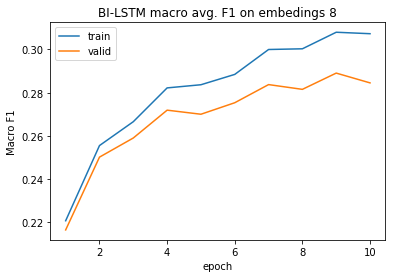

In [62]:
plt.plot(dim,f1_train)
plt.plot(dim,f1_test)
plt.title('BI-LSTM macro avg. F1 on embedings 8')
plt.ylabel('Macro F1')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

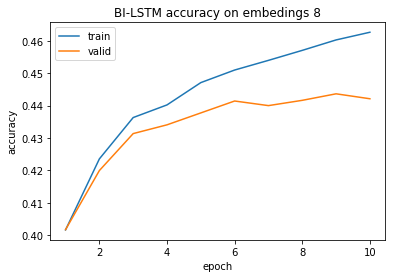

In [61]:
dim=range(1,11)
plt.plot(dim,acc_train)
plt.plot(dim,acc_test)
plt.title('BI-LSTM accuracy on embedings 8')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
